# Create 2 merge files with all csv files and clean the NaN

In [1]:
# Import
import pandas as pd
import os, glob

# Set the path to the directory holding CSV files
DELAY_PATH = 'D:/Utilisateurs/Antoine/Documents/Unnif/5eme cours/Projet inter/CanYouCatchIt/sandbox/data/csv2'

#we merge all csv files in one and change data for classification 
#this part also remove live with NaN 
all_files_csv = glob.glob(os.path.join(DELAY_PATH, "*.csv"))

all_df = []
for f in all_files_csv:
    df = pd.read_csv(f, sep=',')
    all_df.append(df)
    
#merge_3 because there are 3 classes
merged_3_df = pd.concat(all_df, ignore_index=True, sort=False)

merged_3_df=merged_3_df.drop(merged_3_df[merged_3_df.delay.isna()].index)

merged_3_df.loc[merged_3_df.delay >0,"delay"]= 1
merged_3_df.loc[merged_3_df.delay ==0,"delay"]= 0
merged_3_df.loc[merged_3_df.delay <0,"delay"]= -1

merged_3_path = DELAY_PATH + "/merged_3.csv"
merged_3_df.to_csv(merged_3_path,index=False)


merged_5_df = pd.concat(all_df, ignore_index=True, sort=False)

merged_5_df=merged_5_df.drop(merged_5_df[merged_5_df.delay.isna()].index)

merged_5_df.loc[merged_5_df.delay >=10.0,"delay"]= 10
merged_5_df.loc[(merged_5_df.delay >0) & (merged_5_df.delay <10.0),"delay"]= 1
merged_5_df.loc[merged_5_df.delay ==0,"delay"]= 0
merged_5_df.loc[(merged_5_df.delay >-10) & (merged_5_df.delay <0),"delay"]= -1
merged_5_df.loc[merged_5_df.delay <=-10,"delay"]= -10

merged_5_path = DELAY_PATH + "/merged_5.csv"
merged_5_df.to_csv(merged_5_path,index=False)


# Load the data

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt

def load_delay_data(path=merged_3_path):
    """
    Load the cvs file in a panda dataframe
    """
    return pd.read_csv(path)


# load the csv file
delay = load_delay_data()

# Get names of indexes for which column line has not a value of 39
index_to_remove = delay[ delay['line'] != 39].index
# Delete these row indexes from dataFrame
delay.drop(index_to_remove , inplace=True)

# Reset the labels
delay.reset_index(drop=True, inplace=True)

# Stratifie the data with the different hour
# This make sure that the representation of each hour is the same in the train set then in the overall dataset
# This stratification is not necessary is you have enough data
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(delay, delay["hour"]):
    strat_train_set = delay.loc[train_index]
    strat_test_set = delay.loc[test_index]
    



# Plot the data
## 3 classes

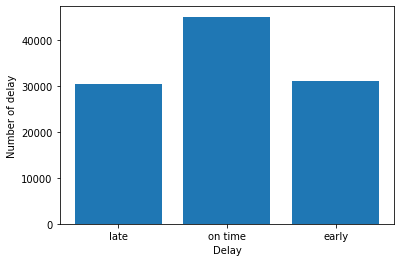

In [3]:
df_3 = pd.read_csv(merged_3_path,1,",")

delay_3 = df_3['delay'].value_counts()
delay_3_ordered = [delay_3[-1],delay_3[0],delay_3[1]]

x= ['late', 'on time', 'early']

plt.bar(x,delay_3_ordered)
plt.xlabel("Delay")
plt.ylabel("Number of delay")

plt.show()

## 5 classes

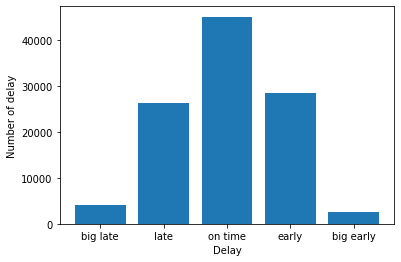

In [4]:
df_5 = pd.read_csv(merged_5_path,1,",")

delay_5 = df_5['delay'].value_counts()
delay_5_ordered = [delay_5[-10],delay_5[-1],delay_5[0],delay_5[1],delay_5[10]]

x= ['big late', 'late', 'on time', 'early','big early']

plt.bar(x,delay_5_ordered)
plt.xlabel("Delay")
plt.ylabel("Number of delay")

plt.show()

when we saw the two graph, we deicded to continue with only 3 classes

## Prepare the Data for Machine Learning Algorithms

In [5]:
delay = strat_train_set.drop("delay", axis=1) # drop labels for training set
delay_labels = strat_train_set["delay"].copy()

### Check if there is row with nan

Count the number of row with a nan value just to be sure even if we clean the data with the scritp

In [6]:
sample_incomplete_rows = delay[delay.isnull().any(axis=1)].head()
len(sample_incomplete_rows.index)

5

### Check if there is attribute that are the same for every row

In [7]:
def unique_cols(df):
    a = df.to_numpy()
    return (a[0] == a).all(0)
unique= unique_cols(delay)
col = list(delay.columns)

for i in delay.columns:
    print(unique[col.index(i)],i)

True transport_type
False trip
False stop
True line
False theoretical_time
False expectedArrivalTime
False date
True direction
True year
True month
False day
False hour
False minute
False temp
False humidity
False visibility
False wind
False rain


### Data Cleaning

Drop the unnecesery attribute. theoretical_time and expectedArrivalTime are droped because they are string attribute and they are not linked to the delay value. The date attribute is split into hour minute and seconds so it can be droped. The transport_type, date_year, date_month, attributes are droped because, it's the same for every row.

In [8]:
nunique = delay.apply(pd.Series.nunique)
cols_to_drop = nunique[nunique == 1].index
delay = delay.drop(cols_to_drop, axis=1)
delay = delay.drop(["trip","theoretical_time", "expectedArrivalTime", "date"], axis=1)
delay.head()

,stop,day,hour,minute,temp,humidity,visibility,wind,rain
47928,5509,1,22,23,279.00,87.0,10000.0,3.60,0.0
34721,5509,0,6,1,280.93,94.0,10000.0,1.67,0.0
40095,5281G,0,19,48,281.65,87.0,10000.0,1.00,0.0
58815,5501,3,19,48,280.87,81.0,10000.0,0.50,0.0
18939,5504,4,19,26,276.71,86.0,10000.0,2.60,0.0


## Handling Text and Categorical Attributes

### Extract the non-numerical attributes

In [9]:
delay_num = delay.drop(['stop'], axis=1)

### Categorical Attributes: The stop and line

In [10]:
delay_cat = delay[['stop']]
delay_cat.head()

,stop
47928,5509
34721,5509
40095,5281G
58815,5501
18939,5504


In [11]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
delay_cat_encoded = ordinal_encoder.fit_transform(delay_cat)
delay_cat_encoded[:5]

array([[8.],
       [8.],
       [1.],
       [2.],
       [5.]])

## Transformation Pipelines


In [12]:
from sklearn.preprocessing import FunctionTransformer
import numpy as np

# get the right column indices: safer than hard-coding indices

def add_extra_features(X, add_combined_time=True):
    hour_ix, minute_ix = [list(delay.columns).index(col) for col in ("hour", "minute")]
    if add_combined_time:
        hour_and_minute = X[:, hour_ix]*3600 + X[:, minute_ix]*60
        return np.c_[X, hour_and_minute]
    else:
        return np.c_[X]

attr_adder = FunctionTransformer(add_extra_features, validate=False,
                                 kw_args={"add_combined_time": True})
delay_extra_attribs = attr_adder.fit_transform(delay.values)

delay_extra_attribs = pd.DataFrame(
    delay_extra_attribs,
    columns=list(delay.columns) + ["hour_and_minute"],
    index=delay.index)
delay_extra_attribs.head()

,stop,day,hour,minute,temp,humidity,visibility,wind,rain,hour_and_minute
47928,5509,1,22,23,279,87,10000,3.6,0,80580
34721,5509,0,6,1,280.93,94,10000,1.67,0,21660
40095,5281G,0,19,48,281.65,87,10000,1,0,71280
58815,5501,3,19,48,280.87,81,10000,0.5,0,71280
18939,5504,4,19,26,276.71,86,10000,2.6,0,69960


In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

num_attribs = list(delay_num)
cat_attribs = ["stop"]

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', FunctionTransformer(add_extra_features,
                                            validate=False,
                                            kw_args={"add_combined_time": True})),
        ('std_scaler', StandardScaler())
    ])

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

delay_prepared = full_pipeline.fit_transform(delay)
delay_prepared

array([[-1.24583412,  1.58367566, -0.38932186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.80662814, -1.52523594, -1.66688894, ...,  0.        ,
         0.        ,  0.        ],
       [-1.80662814,  1.00075473,  1.0624589 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.12424608,  0.02921986, -0.38932186, ...,  0.        ,
         0.        ,  0.        ],
       [-0.6850401 ,  0.41783381, -0.50546432, ...,  0.        ,
         0.        ,  0.        ],
       [-1.24583412, -0.16508712,  0.36560414, ...,  0.        ,
         0.        ,  0.        ]])

## Select and train a model

### split in train and test

In [14]:
X_train, X_test, y_train, y_test = train_test_split(delay_prepared, delay_labels, test_size=0.3) # 70% training and 30% test

### Decision tree

In [15]:
from sklearn import tree

clf_tree = tree.DecisionTreeClassifier(criterion="entropy",min_samples_leaf=100)
clf_tree = clf_tree.fit(X_train, y_train)

print(clf_tree.score(X_train,y_train))
print(clf_tree.score(X_test,y_test))

0.5449036360023842
0.5223387610824592


In [16]:
from sklearn.model_selection import cross_val_score

def display_scores(scores):
    print("Scores: \t\t", scores)
    print("Mean: \t\t\t", scores.mean())
    print("Standard deviation: \t", scores.std())

In [17]:
scores = cross_val_score(clf_tree, X_train, y_train, scoring="accuracy", cv=10)
display_scores(scores)

Scores: 		 [0.52196575 0.52917805 0.52309985 0.51664183 0.52781918 0.5377546
 0.52483855 0.53030303 0.52483855 0.50645802]
Mean: 			 0.5242897398089132
Standard deviation: 	 0.007985576398620681


### Random Forest

In [18]:
from sklearn.utils import class_weight
#compute the weight of a class
def compute_class_weight_dictionary(y):
    # helper for returning a dictionary instead of an array
    classes = np.unique(y)
    weight = class_weight.compute_class_weight("balanced", classes, y)
    class_weight_dict = dict(zip(classes, weight))
    return class_weight_dict

class_weight=compute_class_weight_dictionary(delay_labels)

In [19]:
from sklearn.ensemble import RandomForestClassifier

clf=RandomForestClassifier(n_estimators=100,criterion="entropy",bootstrap=True,min_samples_leaf=300,class_weight=class_weight)
clf.fit(X_train,y_train)
print("class_weight")
print("trained score: ", clf.score(X_train,y_train))
print("test score: ", clf.score(X_test,y_test))
scores = cross_val_score(clf, X_train,y_train, scoring="accuracy", cv=10)
display_scores(scores)

clf=RandomForestClassifier(n_estimators=100,criterion="entropy",bootstrap=True,min_samples_leaf=100)
clf.fit(X_train,y_train)
print("min leaf = 100")
print("trained score: ", clf.score(X_train,y_train))
print("test score: ", clf.score(X_test,y_test))
scores = cross_val_score(clf, X_train,y_train, scoring="accuracy", cv=10)
display_scores(scores)
    


class_weight
trained score:  0.5153486985893105
test score:  0.506403198701976
Scores: 		 [0.50930752 0.51576856 0.49329359 0.49329359 0.50099354 0.51564829
 0.51987084 0.51490313 0.50447094 0.49329359]
Mean: 			 0.5060843593859008
Standard deviation: 	 0.009913676189472663
min leaf = 100
trained score:  0.540035763957878
test score:  0.5244248710668135
Scores: 		 [0.52122115 0.53439285 0.51167412 0.50546448 0.51838053 0.5360159
 0.53974168 0.52583209 0.53452558 0.51614506]
Mean: 			 0.5243393428641745
Standard deviation: 	 0.010998545037508774


### KNN

In [20]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=50,leaf_size=300)
knn.fit(X_train, y_train)

print("trained score: ", knn.score(X_train,y_train))
print("test score: ", knn.score(X_test,y_test))

scores = cross_val_score(knn, X_train,y_train, scoring="accuracy", cv=10)
display_scores(scores)

trained score:  0.5591843830717266
test score:  0.5268007185489946
Scores: 		 [0.53139737 0.5443258  0.51987084 0.52459016 0.53477397 0.5273224
 0.53725782 0.5360159  0.53800298 0.51738698]
Mean: 			 0.5310944233008429
Standard deviation: 	 0.008179443655120563


## take a look on grid search 
### grid search for random forest 

In [21]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 72 (2x3x4x3) combinations of hyperparameters    
    {'bootstrap': [False,True], 'n_estimators': [5,10,100], 'max_features': [2, 3, 4,8],'min_samples_leaf': [100,200,500]},
  ]

forest_class = RandomForestClassifier(random_state=42)
# train across 5 folds, that's a total of (72)*5=360 rounds of training 
grid_search = GridSearchCV(forest_class, param_grid, cv=5, scoring='accuracy', return_train_score=True)
grid_search.fit(delay_prepared, delay_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{

In [22]:
grid_search.best_params_

{'bootstrap': False,
 'max_features': 8,
 'min_samples_leaf': 100,
 'n_estimators': 100}

In [23]:
cvres = grid_search.cv_results_
for mean_train_score, mean_score, params in zip(cvres["mean_train_score"],cvres["mean_test_score"], cvres["params"]):
    print(mean_train_score,mean_score, params)

0.5312668095066226 0.512299855704873 {'bootstrap': False, 'max_features': 2, 'min_samples_leaf': 100, 'n_estimators': 5}
0.5365301570543701 0.5149771387840962 {'bootstrap': False, 'max_features': 2, 'min_samples_leaf': 100, 'n_estimators': 10}
0.5453834109131174 0.5232523773926044 {'bootstrap': False, 'max_features': 2, 'min_samples_leaf': 100, 'n_estimators': 100}
0.5162462175055726 0.5040246170963648 {'bootstrap': False, 'max_features': 2, 'min_samples_leaf': 200, 'n_estimators': 5}
0.5206533106239473 0.5098485770414284 {'bootstrap': False, 'max_features': 2, 'min_samples_leaf': 200, 'n_estimators': 10}
0.5251299417498168 0.5131169485926879 {'bootstrap': False, 'max_features': 2, 'min_samples_leaf': 200, 'n_estimators': 100}
0.4947888455307898 0.4890561707897985 {'bootstrap': False, 'max_features': 2, 'min_samples_leaf': 500, 'n_estimators': 5}
0.5017384844566367 0.49698371029710886 {'bootstrap': False, 'max_features': 2, 'min_samples_leaf': 500, 'n_estimators': 10}
0.507197339173456

In [24]:
clf=RandomForestClassifier(n_estimators=100,criterion="entropy",bootstrap=False,min_samples_leaf=100,max_features=8)
clf.fit(X_train,y_train)
print("class_weight")
print("trained score: ", clf.score(X_train,y_train))
print("test score: ", clf.score(X_test,y_test))
scores = cross_val_score(clf, X_train, y_train, scoring="accuracy", cv=10)
display_scores(scores)

class_weight
trained score:  0.5631581561692828
test score:  0.5419250159355624
Scores: 		 [0.53884339 0.55103054 0.54048684 0.51862891 0.53874814 0.54297069
 0.55663189 0.54992548 0.5496771  0.52881272]
Mean: 			 0.5415755697789321
Standard deviation: 	 0.010767895123969255


if we take a depper look on the scores, we can see that it is always with the min_sample_leaf = 100 that we have better results
take let's try this with smaller value

In [25]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 64 (2x4x2x4) combinations of hyperparameters    
    {'bootstrap': [False,True], 'max_features': [2, 3, 4,8],'criterion' : ["entropy","gini"],'min_samples_leaf': [10,30,50,100]},
  ]

forest_class = RandomForestClassifier(random_state=42,n_estimators=10)
# train across 5 folds, that's a total of (64)*5=320 rounds of training 
grid_search = GridSearchCV(forest_class, param_grid, cv=5, scoring='accuracy', return_train_score=True)
grid_search.fit(delay_prepared, delay_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=10, n_jobs=None,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'boo

In [26]:
grid_search.best_params_

{'bootstrap': False,
 'criterion': 'entropy',
 'max_features': 8,
 'min_samples_leaf': 10}

In [27]:
cvres = grid_search.cv_results_
for mean_train_score, mean_score, params in zip(cvres["mean_train_score"],cvres["mean_test_score"], cvres["params"]):
    print(mean_train_score,mean_score, params)

0.6654786314870089 0.5404634829018967 {'bootstrap': False, 'criterion': 'entropy', 'max_features': 2, 'min_samples_leaf': 10}
0.5835172927853404 0.5355435406199475 {'bootstrap': False, 'criterion': 'entropy', 'max_features': 2, 'min_samples_leaf': 30}
0.5569270338123956 0.5263468993932651 {'bootstrap': False, 'criterion': 'entropy', 'max_features': 2, 'min_samples_leaf': 50}
0.5355435248118392 0.5165243997844265 {'bootstrap': False, 'criterion': 'entropy', 'max_features': 2, 'min_samples_leaf': 100}
0.6698727092757177 0.5537108186575338 {'bootstrap': False, 'criterion': 'entropy', 'max_features': 3, 'min_samples_leaf': 10}
0.5888327474637457 0.5432450757114793 {'bootstrap': False, 'criterion': 'entropy', 'max_features': 3, 'min_samples_leaf': 30}
0.5658107255655983 0.5358564698110255 {'bootstrap': False, 'criterion': 'entropy', 'max_features': 3, 'min_samples_leaf': 50}
0.5433276514610578 0.5263468993932651 {'bootstrap': False, 'criterion': 'entropy', 'max_features': 3, 'min_samples_le

we can see that if we choose 10 on the min_sample_leaf, we start to have an overfit it's a small overfit wich allows to have a better scores on the test set but it is not the right things to do, according to me, we have to choose between 30 and 50, 30 seem to be the best. we wan also see that gini is the best we can remove it from the grid, it is the default criterion 

In [28]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 6 (2x3) combinations of hyperparameters    
    {'bootstrap': [False,True], 'max_features': [4,8,"auto"]},
  ]

forest_class = RandomForestClassifier(random_state=42,n_estimators=10,min_samples_leaf=30)
# train across 5 folds, that's a total of (6)*5=30 rounds of training 
grid_search = GridSearchCV(forest_class, param_grid, cv=5, scoring='accuracy', return_train_score=True)
grid_search.fit(delay_prepared, delay_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=30,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=10, n_jobs=None,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'bo

In [29]:
grid_search.best_params_

{'bootstrap': False, 'max_features': 8}

In [30]:
cvres = grid_search.cv_results_
for mean_train_score, mean_score, params in zip(cvres["mean_train_score"],cvres["mean_test_score"], cvres["params"]):
    print(mean_train_score,mean_score, params)

0.5998635351197381 0.5482693277237878 {'bootstrap': False, 'max_features': 4}
0.6232202242586414 0.5636028580866118 {'bootstrap': False, 'max_features': 8}
0.6077432286397724 0.5537108186575338 {'bootstrap': False, 'max_features': 'auto'}
0.5753550807094572 0.5410893412840527 {'bootstrap': True, 'max_features': 4}
0.5976817029884365 0.555101615062325 {'bootstrap': True, 'max_features': 8}
0.584403936469009 0.5462352879817806 {'bootstrap': True, 'max_features': 'auto'}


the choice belong to us now, I would say that i agree with the best_params_ even if the train scores is 5% higher than the test, it is negligible

In [31]:
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("classifier", RandomForestClassifier(random_state=42,n_estimators=10,min_samples_leaf=30,bootstrap=False,max_features=8))
    ])
full_pipeline_with_predictor.fit(delay, delay_labels)

test_set = strat_test_set.drop("delay", axis=1) # drop labels for test set
test_set_labels = strat_test_set["delay"].copy()
print(test_set_labels[500:510].array)
print(list(full_pipeline_with_predictor.predict(test_set[500:510])))

<PandasArray>
[0.0, 0.0, -1.0, 0.0, -1.0, 0.0, 0.0, 1.0, -1.0, -1.0]
Length: 10, dtype: float64
[1.0, 0.0, 1.0, 0.0, -1.0, 1.0, 0.0, 1.0, -1.0, 1.0]


we can see that 6 predictions on 10 are correct. With 56% of right answer, it seem to correspond 

### Save the model 

In [32]:
import joblib

save_path = 'D:/Utilisateurs/Antoine/Documents/Unnif/5eme cours/Projet inter/CanYouCatchIt/sandbox/classification/models/forest_model.pkl'

forest_model = full_pipeline_with_predictor
joblib.dump(forest_model, save_path) # save

# my_model_loaded = joblib.load("my_model.pkl") # load

['D:/Utilisateurs/Antoine/Documents/Unnif/5eme cours/Projet inter/CanYouCatchIt/sandbox/classification/models/forest_model.pkl']